In [5]:
import numpy as np
import pandas as pd
# Custom Libraries for saving excel and transformation of variables
import os
import sys
module_path = os.path.abspath(os.path.join('../../src/utils'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
# from custom_mmm_modelling import MMM_Modelling
from custom_mmm_modelling_v3 import MMM_Modelling
from custom_modelling_plots import ModellingPlots


import pdb
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

import pickle
import itertools

import time

In [6]:
%pwd

'/home/jupyter/zlu/mmm/Modeling Codebase Example/Modeling/OLS Model/auto folder_structure/notebook/modelling'

In [7]:
# %pwd
# 'C:\\Users\\m0y01ey\\Desktop\\Measurment Science\\Kelloggs\\Brand 1 Frosted Flakes\\2. Modeling\\auto folder_structure (added flexibility to choose media metric)\\notebook\\modelling'

In [8]:
# To display numbers in decimal separated format
pd.options.display.float_format = '{:20,.5f}'.format

pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', -1)  # or 199

In [9]:
media_dictionary = {'IMP' : 'Impression',
                    'SPEND' : 'Spend',
                    'VIEW_IMP' : 'Viewable Impression',
                    'CLK' : 'Click'}

In [10]:
# User Inputs
target_var = 'O_UNIT'

# standard names for folders are: new_customer_online, new_customer, sales_unit_online, sales_unit. 
# however the user can choose any folder name
# the folder would be created in models/manual_models
folder_name = 'sales_unit'

# standard names for folders are mix_media_metrics, impression, click, spend, viewable_impression
sub_folder = 'Hyperopt'

# input files
input_data_path = "../../data/processed_input_data/02_modelling_stack_data_seasonality.csv"
#"../../data/processed_input_data/02_modelling_stack_data_seasonality.csv"

# Loading data dictionary
data_dict = pd.read_excel("../../data/input_data/WMG WAMM Project Data Dictionary_v12.xlsx") 
#"../../data/input_data/WMG WAMM Project Data Dictionary_v20.xlsx")

In [11]:
# loading media hierarchy mapping
media_hier_click = pd.read_csv("../../data/input_data/media_hierarchy_CLK.csv")
media_hier_imp = pd.read_csv("../../data/input_data/media_hierarchy_IMP.csv")
media_hier_view_imp = pd.read_csv("../../data/input_data/media_hierarchy_VIEW_IMP.csv")
media_hier_spend = pd.read_csv("../../data/input_data/media_hierarchy_SPEND.csv")

media_hier = pd.concat([media_hier_click, media_hier_imp, media_hier_view_imp, media_hier_spend], axis= 0)

In [12]:
try:
    os.mkdir("../../models/{}/".format('manual'))
except:
    print("manual folder already exists")
    
folder_path = "../../models/manual/{}/".format(folder_name)
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")
    
folder_path += sub_folder + "/"
try:
    os.mkdir(folder_path)
except:
    print(folder_path + " folder already exists")

manual folder already exists
../../models/manual/sales_unit/ folder already exists


In [13]:
#loading data file
df = pd.read_csv(input_data_path, thousands= ",", na_values = " -   ")
df['index'] = pd.to_datetime(df['index']) # Formatting the date
df.set_index("index", inplace = True, drop= False) 

df['M_SEARCH_MAN_CLK']=df['M_SBA_CLK']+df['M_SP_KWB_CLK']
df['M_SEARCH_AUTO_CLK']=df['M_SP_AB_CLK']

In [14]:
#Put dummy spends for national media to not break down in built in ROAS calculations
#df['M_NATIONAL_SEARCH_ECOMM_SPEND']=1000
# df['M_NATIONAL_TV_SPEND']=1000 
df['M_SEARCH_MAN_SPEND']=df['M_SBA_SPEND']+df['M_SP_KWB_SPEND']
df['M_SEARCH_AUTO_SPEND']=df['M_SP_AB_SPEND']
#df['M_NATIONAL_AUDIO_SPEND']=1000
#df['M_NATIONAL_DISPLAY_ECOMM_SPEND']=1000
#df['M_NATIONAL_SEARCH_SPEND']=1000
#df['M_NATIONAL_DISPLAY_SPEND']=1000
#df['M_NATIONAL_VIDEO_SPEND']=1000

In [15]:
#crop data acording to the training/testing dates
df.shape
# category model
# 1158, 230

(851, 479)

#### As soon as the object of class MMM_Modelling is created, folder would be created in the specified folder_path variable. The folder would follow the naming convention of date(yyyy-mm-dd)_model_outputs_v*. 

In [16]:
# Creating the modelling object
model_obj = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                          output_path= folder_path, media_hier= media_hier, #save_result = False,
                          apply_adstock = True,
                          comment= 'Media Mix Model')

In [17]:
# date 2019-01-01 to 2020-12-31
# previou report used: 2019-01-01 - 2020-12-21
#()'2019-01-01', '2021-03-31', '2021-04-01', '2021-04-30')

# train_start = '2019-10-01'
train_start = '2019-01-01'
train_end = '2021-03-31'

test_start = '2021-04-01'
test_end = '2021-04-30'
# ('2020-05-01', '2021-05-31', '2020-05-01', '2021-05-31')

In [18]:
model_obj.create_train_test_split(train_start, train_end, test_start, test_end)

In [19]:
# media variables from Erim
                  

In [20]:
# Set up the independent variable space

# Variable selection
dummy_variables = ['D_HOL_CHRISTMAS',
                   'D_NATIONAL_WEATHER',
                   'D_HOL_THANKSGIVING',
                   'D_HOL_NEW_YEARS_DAY',
                   'D_HOL_EASTER',
                   'D_EVENT_COVID_LOCKDOWN',
                   'D_EVENT_PRE_SUPERBOWL',
                   'D_DAY_SUNDAY',
                   'D_EVENT_COVID_STOCKUP',
                   'D_EVENT_COVID_BURN',
                   'D_EVENT_EXTREME_COLD']

# sample transformations from Erim
# media_variables =   ['M_ON_DIS_AT_IMP_14_8_2_6_0', 
#                     'M_ON_DIS_CT_ROS_IMP_6_3_3_12_0',
#                     'M_ON_DIS_HPLO_IMP_6_0_1_1_0',  
#                     'M_ON_DIS_KW_IMP_5_0_6_4_0',  
#                     'M_OFF_DIS_WN_IMP_5_6_5_7_0',  
#                     'M_OFF_DIS_PIN_IMP_7_8_5_8_0',  
#                     'M_NATIONAL_TV_IMP_7_8_1_12_0',
#                     'M_SEARCH_AUTO_CLK_1_4_3_5_0', 
#                     'M_SEARCH_MAN_CLK_2_1_4_4_0'
#                    ]


# c-curve config:  INFILE and SCALE are set to be 0.0
#                  LAG          HALF          INFLE             SCALE            CLEVEL
# kw_config   =  [[0,  5, 1], [0,  5, 1], [0.0, 0.001, 0.4], [0.0, 0.001, 0.4], [0.1, 6.5, 0.2]]
# kw_default = [[0], [0], [0.0], [0.0], [0.2]]
# nonkw_config = [[0, 18, 1], [0, 11, 1], [0.0, 0.001, 0.4], [0.0, 0.001, 0.4], [0.1, 6.5, 0.2]]
# nonkw_default = [[3], [2], [0.0], [0.0], [0.2]]

# s-curves config: CLEVEL is set to be 0.0
#                  LAG        HALF          INFLE             SCALE            CLEVEL
kw_config   =  [[0,  5, 1], [0,  5, 1], [0.3, 7.0, 0.4], [0.3, 7.0, 0.4], [0.0, 0.001, 0.1]]
kw_default = [[0], [0], [3.0], [3.0], [0.0]]
nonkw_config = [[0, 15, 1], [0, 10, 1], [0.3, 7.0, 0.4], [0.3, 7.0, 0.4], [0.0, 0.001, 0.1]]
nonkw_default = [[3], [2], [3.0], [3.0], [0.0]]

                    
# Choose the media list in media_config
media_config = {
 'M_ON_DIS_AT_IMP': nonkw_config + nonkw_default,              
 'M_ON_DIS_CT_ROS_IMP':   nonkw_config + nonkw_default,
 'M_ON_DIS_HPLO_IMP':  nonkw_config + nonkw_default,
 'M_ON_DIS_KW_IMP':    kw_config    + kw_default, 
 'M_OFF_DIS_WN_IMP':   nonkw_config + nonkw_default,                                     
 'M_OFF_DIS_PIN_IMP':   nonkw_config + nonkw_default,     
 'M_NATIONAL_TV_IMP':   nonkw_config + nonkw_default,             
 'M_SEARCH_AUTO_CLK':  kw_config + kw_default,
 'M_SEARCH_MAN_CLK':   kw_config + kw_default, 
}


    
media_param_tags = ['LAG', 'HALF', 'INFLE', 'SCALE', 'CLEVEL']
media_list = list(media_config.keys())

#Put the config data into a dataframe for media variables 
for i, k in enumerate(media_config.keys()):
    vals =  media_config[k]
#     print(k)
    new_df = pd.DataFrame({'index':[i],
                           'Variables':  [k], 
                            'LAG_lower':  vals[0][0], 'LAG_upper':vals[0][1], 'LAG_step':vals[0][2],
                            'HALF_lower': vals[1][0], 'HALF_upper':vals[1][1], 'HALF_step':vals[1][2],
                            'INFLE_lower': vals[2][0], 'INFLE_upper':vals[2][1], 'INFLE_step':vals[2][2],
                            'SCALE_lower': vals[3][0], 'SCALE_upper':vals[3][1], 'SCALE_step':vals[3][2],
                            'CLEVEL_lower': vals[4][0], 'CLEVEL_upper':vals[4][1], 'CLEVEL_step':vals[4][2],
                            'LAG_init': vals[5][0],
                            'HALF_init': vals[6][0],
                            'INFLE_init': vals[7][0],
                            'SCALE_init': vals[8][0],
                            'CLEVEL_init': vals[9][0],
                            'Final Variables': k + '_' + str(vals[5][0]) + '_' + str(vals[6][0]) + '_' 
                                                 + str(vals[7][0]) + '_' + str(vals[8][0]) + '_' + str(vals[9][0])
                          })
    if i==0:
        media_df = new_df.copy()
    else:
        media_df = pd.concat([media_df, new_df])

media_df.set_index(keys=['index'], drop=True,inplace=True)
# print(media_df)


 
other_variables = ['O_UNIT_SEASONALITY',
                   'O_UNIT_RESIDUAL',
                   'INVENTORY_STORE_SELLABLE_ITEMS_COUNT',
                   'PRICE'
                  ]




In [21]:
# set up search space for given media variable data configuration: media_df 

def set_up_search_space(sub_med_list, med_list, media_df):
    global media_param_tags
    
    f_space = {}
    for i, m_key in enumerate(med_list):
        if (m_key in sub_med_list):
            # set a search range for params
            for tag in media_param_tags[0:2]:  # for lag and halflife
                param_key = m_key + '_' + tag
                param_df = media_df[media_df['Variables'] == m_key]
                f_space[param_key] = hp.randint(param_key, 
                                               param_df[tag + '_lower'].values[0], 
                                               param_df[tag + '_upper'].values[0])
            for tag in media_param_tags[2:]:  # for (inflection, scale) and clevel
                param_key = m_key + '_' + tag
                param_df = media_df[media_df['Variables'] == m_key]
                f_space[param_key] = hp.quniform(param_key, 
                                               param_df[tag + '_lower'].values[0], 
                                               param_df[tag + '_upper'].values[0], 
                                               param_df[tag + '_step'].values[0])
#                 f_space[param_key] = hp.uniform(param_key, 
#                                                param_df[tag + '_lower'].values[0], 
#                                                param_df[tag + '_upper'].values[0])

        else:
            # set a fixed values for params
            for tag in media_param_tags[0:2]:  # for lag and halflife
                param_key = m_key + '_' + tag
                param_df = media_df[media_df['Variables'] == m_key]
                f_space[param_key] = hp.randint(param_key, 
                                               param_df[tag + '_init'].values[0], 
                                               param_df[tag + '_init'].values[0] + 1)
            for tag in media_param_tags[2:]:  # for for (inflection, scale) and clevel
                param_key = m_key + '_' + tag
                param_df = media_df[media_df['Variables'] == m_key]
                f_space[param_key] = hp.quniform(param_key, 
                                               param_df[tag + '_init'].values[0], 
                                               param_df[tag + '_init'].values[0] + 0.001, 
                                               param_df[tag + '_step'].values[0])
#                 f_space[param_key] = hp.uniform(param_key, 
#                                                param_df[tag + '_init'].values[0], 
#                                                param_df[tag + '_init'].values[0]+0.0001)
    return f_space


In [22]:
str(round(0.1234,2))

'0.12'

In [23]:
# Variable selection

# updated naming convention of media transformation: lag_halflife_inflection_scale_ccurve-toggle
# keep values of inflection and scale as zero to turn off the S-Curve
# keep value of ccurve toggle as zero to turn off c-curve toggle

#function to evaluate each trial
n_itr = 0
def f(params):
    global n_itr
    
    media_variables=[]
    for i in media_list:
        var = i+'_LAG'
        lag = params[var]
        var = i+'_HALF'
        half = params[var]
        var = i+'_INFLE'
        infle = round(params[var], 2)
        var = i+'_SCALE'
#         scale  = '{:.2f}'.format(params[var])
        scale = round(params[var], 2)
        var = i + '_CLEVEL'
        clevel = round(params[var], 3)
        final_var = i + '_'+str(lag) + '_' + str(half) + '_' + str(infle) + '_' + str(scale)+ '_' + str(clevel)
        media_variables.append(final_var)
    

#     base_variables = ['O_UNIT_SMA_DAY_'  + str(params['MA']) ] + other_variables
    base_variables =  other_variables
    
    # Creating the modelling object
    model_obj = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                              output_path= folder_path, media_hier= media_hier, save_result = False,
                              apply_adstock = True,
                              comment= 'Media Mix Model')
    model_obj.create_train_test_split( train_start, train_end, test_start, test_end)

    # Selecting all the independent variables
    all_independent_variables = dummy_variables + media_variables + base_variables
    model_obj.create_missing_media_transformations(media_variables, 
                                                   trans_start_date= train_start, trans_end_date= train_end)
    
    model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')

# Calculate the objective functions
#
# 1. Prefer positive coefficients and small p-values
    coeff_summary = model_obj.model_dump['Manual Model 1']['Coefficient Summary'].copy()
    ddf = coeff_summary[coeff_summary['Variables'].str.startswith("M_")].copy()
    ddf.loc[ddf['Coefficient']<0.0, 'p-value'] = 1.0
    
    imp_ddf = ddf[ddf['Variables'].str.contains("_IMP")]
    clk_ddf = ddf[ddf['Variables'].str.contains("_CLK")]
    
#     coefs = ddf['Coefficient']
#     coef_hhi = 100 * (coefs**2).sum()/(coefs.abs().sum()**2)

    clk_imp_ratio = 0.01 #0.001

    #set up coefficients. penalize negative coefs and large p values
    neg_coefs = (imp_ddf[imp_ddf['Coefficient']<0.0]['Coefficient'].sum() + 
                    clk_imp_ratio * clk_ddf[clk_ddf['Coefficient']<0.0]['Coefficient'].sum() 
                )
    
    pos_coefs = (imp_ddf[imp_ddf['Coefficient']>=0.0]['Coefficient'].sum() + 
                 clk_imp_ratio * clk_ddf[clk_ddf['Coefficient']>=0.0]['Coefficient'].sum() 
                )
    
    
    large_p = ddf[ddf['p-value'] > 0.25]['p-value'].sum()
    small_p = ddf[ddf['p-value'] <= 0.25]['p-value'].sum()

#     obj = -neg_coefs*10000000 - pos_coefs
    obj0 = -neg_coefs*1000000000 - pos_coefs + large_p*10000000 + small_p

    
# 2. bigger log-likelihood or small enough MAPE (< 10)
    mdl_stats = model_obj.model_dump['Manual Model 1']['Modelling Stats']
#     LL = mdl_stats.loc[['Log Likelihood']]['Model Fit'][0]
    MAPE = mdl_stats.loc[['MAPE']]['Model Fit'][0]
    mape_min = 10.0
#     val  = obj + large_p*10000 + small_p*1
    obj2 =  10.0*((MAPE > mape_min) * (MAPE - mape_min)**2)

# 3. Moderate RoAS for each media variable:
    roas_stats = model_obj.calculate_ROAS('Manual Model 1', start_date= model_obj.modelling_start, end_date= model_obj.modelling_end)
    roas_stats.replace([np.inf, -np.inf, np.nan], 0.0, inplace=True)
    if model_obj.target_var == 'O_UNIT':
        roas_tag = 'Value RoAS ($)'
    else:
        roas_tag = 'Value NCoAS ($)'
    max_roas = roas_stats[roas_tag].max()/100.0
    roas_limit = 50.0
    obj3 = 1000.0 * ((max_roas > roas_limit)*(max_roas - roas_limit)**2) 
    
# 4. Moderate incremental lift for each media variable:
# range [ 2% - 10%]
    total_contribution = roas_stats['Total Contribution'].sum()
    total_val = model_obj.df[(model_obj.df.index >= model_obj.modelling_start) & (model_obj.df.index <= model_obj.modelling_start)][model_obj.target_var].sum()
    contrb_rate = total_contribution/(0.01 + total_val)
    
    c_target = 5.0
    obj4 = 100.0 * ((100*contrb_rate - c_target)**2)

#     val = obj0 + obj1 + obj2 + obj3 + obj4
    val = obj0 + obj3
    
    if(n_itr%200 == 0):
        print("itr = "+ str(n_itr) + ' loss = {:.2f}'.format(val))
        print("MAPE={:.2f}".format(MAPE),  "  max_roas($)={:.2f}".format(max_roas),"contribution_rate={:.3f}".format(contrb_rate))

    n_itr += 1
    return {'loss': val, 'status': STATUS_OK}



In [24]:
# run the thing with saved trials


def run_trials(space, more_trials = 10, load_trials = False, trial_mark = 0, run_no = '0830'):

    trials_step = more_trials # how many additional trials to do after loading saved trials. 1 = save after iteration
    max_trials = more_trials  # initial max_trials. put something small to not have to wait

    if load_trials:
        try:  # try to load an already saved trials object, and increase the max
            saved_trials = folder_path + "model_trials_" + run_no + ".hyperopt"
            trials = pickle.load(open(saved_trials, "rb"))
            print("Found saved Trials! Loading...")
            max_trials = len(trials.trials) + trials_step

            print("Rerunning from {} trials to {} (+{}) trials in trial_mark {}".format(len(trials.trials), max_trials, trials_step, trial_mark))
        except:  # create a new trials object and start searching
            trials = Trials()
    else:
        trials = Trials()

    best = fmin(fn=f, space=space, algo=tpe.suggest, max_evals=max_trials, trials=trials)
    best_loss = trials.best_trial['result']['loss']
    
#     print("Best:", best)
    
    # save the trials object
    if load_trials:
        with open(saved_trials, "wb") as model_f:
            pickle.dump(trials, model_f)

    saved_trials_1 = folder_path + "model_trials_" + run_no + "_{}.hyperopt".format(trial_mark) #, len(trials.trials))
    with open(saved_trials_1, "wb") as model_f:
        pickle.dump(trials, model_f)
        
    return best, best_loss



In [25]:

# create sub_space to search: return 1 list of media variable list.  
# Each element is a subspace to search.
# The 1st subspace is the full space

def create_search_subspace(media_list, dim_subspace = 3, nitr_subspace=3, start_full_dim = True):
    if dim_subspace > 4:
        # limit sub_space dim to <= 4
        dim_subspace = 4
    long_media_list = media_list + media_list # + media_list +  media_list
    
    combin3 = []
    for i in range(len(media_list)):
        ii = i * dim_subspace
        if (ii < len(media_list)):
            combin3 = combin3 + [long_media_list[ii:(ii + dim_subspace)]]

    # Or start with whole space 
    if (start_full_dim is False):
        init_list = [[c] for c in media_list] 
    else:
        init_list = [media_list]
            
    #then loop 3 times in the 2-media-variable sub-space
    repeat_list = []
    for i in range(nitr_subspace):
        repeat_list =  repeat_list + combin3
        
    m_list = init_list + repeat_list

    return m_list
    

In [26]:
clist = create_search_subspace(media_list, dim_subspace = 2, nitr_subspace=4, start_full_dim = True)
clist

[['M_ON_DIS_AT_IMP',
  'M_ON_DIS_CT_ROS_IMP',
  'M_ON_DIS_HPLO_IMP',
  'M_ON_DIS_KW_IMP',
  'M_OFF_DIS_WN_IMP',
  'M_OFF_DIS_PIN_IMP',
  'M_NATIONAL_TV_IMP',
  'M_SEARCH_AUTO_CLK',
  'M_SEARCH_MAN_CLK'],
 ['M_ON_DIS_AT_IMP', 'M_ON_DIS_CT_ROS_IMP'],
 ['M_ON_DIS_HPLO_IMP', 'M_ON_DIS_KW_IMP'],
 ['M_OFF_DIS_WN_IMP', 'M_OFF_DIS_PIN_IMP'],
 ['M_NATIONAL_TV_IMP', 'M_SEARCH_AUTO_CLK'],
 ['M_SEARCH_MAN_CLK', 'M_ON_DIS_AT_IMP'],
 ['M_ON_DIS_AT_IMP', 'M_ON_DIS_CT_ROS_IMP'],
 ['M_ON_DIS_HPLO_IMP', 'M_ON_DIS_KW_IMP'],
 ['M_OFF_DIS_WN_IMP', 'M_OFF_DIS_PIN_IMP'],
 ['M_NATIONAL_TV_IMP', 'M_SEARCH_AUTO_CLK'],
 ['M_SEARCH_MAN_CLK', 'M_ON_DIS_AT_IMP'],
 ['M_ON_DIS_AT_IMP', 'M_ON_DIS_CT_ROS_IMP'],
 ['M_ON_DIS_HPLO_IMP', 'M_ON_DIS_KW_IMP'],
 ['M_OFF_DIS_WN_IMP', 'M_OFF_DIS_PIN_IMP'],
 ['M_NATIONAL_TV_IMP', 'M_SEARCH_AUTO_CLK'],
 ['M_SEARCH_MAN_CLK', 'M_ON_DIS_AT_IMP'],
 ['M_ON_DIS_AT_IMP', 'M_ON_DIS_CT_ROS_IMP'],
 ['M_ON_DIS_HPLO_IMP', 'M_ON_DIS_KW_IMP'],
 ['M_OFF_DIS_WN_IMP', 'M_OFF_DIS_PIN_IMP'],
 ['M_NA

In [39]:
# Set up search subspace by a list of n-tuple media_varaible list

dim_of_subspace = 2
n_itr_time = 3

combins = create_search_subspace(media_list, 
                                 dim_subspace = dim_of_subspace, 
                                 nitr_subspace = n_itr_time, 
                                 start_full_dim = True)

# df to host the parameters
media_run_df = media_df.copy()

# running experiment tag -- use a unique tag

init_itr = 2000  # first iteration number in full space

# subsequential iteration number in sub-space.  
# 1. choose 
# seq_itr = 300  for 2-media-var sub-space
# seq_itr = 1000 for 3-media-var sub-space
#
seq_itr = 500

run_tag = 'test_d' + str(dim_of_subspace) + 'n' + str(n_itr_time) + 'i' + str(seq_itr)

print(run_tag, " used as run_tag for saved files.")


test_d2n3i500  used as run_tag for saved files.


In [28]:
# run the iterations

n_itr = 0
for k, cmb in enumerate(combins):
    
    # set up 
    fspace_run = set_up_search_space(sub_med_list=cmb, med_list=media_list, media_df = media_run_df)
    
    if (len(cmb) == 1) | (len(cmb) == len(media_list)):
        nt = init_itr
    else:
        nt = seq_itr

    best, best_loss = run_trials(space = fspace_run, load_trials = False, 
                                 more_trials = nt, trial_mark = k, run_no = run_tag)

    #Transform the best solution to evaluate final model 
    media_variables=[]
    for mv in media_list:
        var = mv +'_LAG'
        lag = best[var]
        var = mv +'_HALF'
        half = best[var]
        var = mv +'_INFLE'
        infle = round(best[var],2)
        var = mv +'_SCALE'
        scale = round(best[var],2)
        var = mv +'_CLEVEL'
        clevel = round(best[var],3)
        final_var = mv +'_' + str(lag) + '_' + str(half) + '_' + str(infle) + '_' + str(scale) + '_' + str(clevel)
        media_variables.append(final_var)
        
        # carry the best parameter to next stage
        media_run_df.loc[media_run_df['Variables'] == mv, 'LAG_init'] = lag
        media_run_df.loc[media_run_df['Variables'] == mv, 'HALF_init'] = half
        media_run_df.loc[media_run_df['Variables'] == mv, 'INFLE_init'] = infle
        media_run_df.loc[media_run_df['Variables'] == mv, 'SCALE_init'] = scale
        media_run_df.loc[media_run_df['Variables'] == mv, 'CLEVEL_init'] = clevel
        media_run_df.loc[media_run_df['Variables'] == mv, 'Final Variables'] = final_var
        
    best_model_record = media_run_df[['Variables', 'Final Variables']].copy()
    best_model_record['itr'] = k
    best_model_record['loss'] = best_loss
    best_model_record['active'] = 0
    for cv in cmb:
        best_model_record.loc[best_model_record['Variables'] == cv, 'active'] = 1
        
    if k == 0:
        model_records = best_model_record.copy()
    else:
        model_records = pd.concat([model_records, best_model_record])
        

#save the best models in each iterations
model_records.to_csv(folder_path + "best_models_" + run_tag + ".csv", index=False)

# Creating the finale modelling object
model_obj = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                              output_path= folder_path, media_hier= media_hier,
                              apply_adstock = True,
                              comment= 'Media Mix Model')

model_obj.create_train_test_split( train_start, train_end, test_start, test_end)

# Selecting all the independent variables
#use media_variables in the modeling notebook
all_independent_variables = dummy_variables + media_variables + other_variables
model_obj.create_missing_media_transformations(media_variables, 
                                               trans_start_date= train_start, trans_end_date= train_end)

model_obj.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')

coeff_summary = model_obj.model_dump['Manual Model 1']['Coefficient Summary']

print(coeff_summary[['Variables', 'Coefficient', 'p-value']])
  
    

itr = 0 loss = 1226090997.78                          
MAPE=7.43                                             
  max_roas($)=13.53                                   
contribution_rate=-8.160                              
100%|██████████| 20/20 [00:14<00:00,  1.40trial/s, best loss: 31386512.73778444]
itr = 200 loss = 32085599.36                          
MAPE=6.68                                             
  max_roas($)=2.75                                    
contribution_rate=4.989                               
100%|██████████| 20/20 [00:14<00:00,  1.42trial/s, best loss: 27657045.810197875]
                               Variables          Coefficient  \
0   INTERCEPT_TERM                              117,600.65717   
1   D_HOL_CHRISTMAS                              -6,234.11018   
2   D_NATIONAL_WEATHER                               95.87926   
3   D_HOL_THANKSGIVING                          -13,541.62214   
4   D_HOL_NEW_YEARS_DAY                          -3,571.38281   
5   D_H

In [29]:
# model_obj.modelling_stats
model_obj.model_dump['Manual Model 1']['Coefficient Summary']


Variables          Coefficient  \
0   INTERCEPT_TERM                              117,600.65717   
1   D_HOL_CHRISTMAS                              -6,234.11018   
2   D_NATIONAL_WEATHER                               95.87926   
3   D_HOL_THANKSGIVING                          -13,541.62214   
4   D_HOL_NEW_YEARS_DAY                          -3,571.38281   
5   D_HOL_EASTER                                 -9,191.13181   
6   D_EVENT_COVID_LOCKDOWN                       28,574.21072   
7   D_EVENT_PRE_SUPERBOWL                         4,263.35776   
8   D_DAY_SUNDAY                                    901.09221   
9   D_EVENT_COVID_STOCKUP                        33,673.29238   
10  D_EVENT_COVID_BURN                           -6,631.86393   
11  D_EVENT_EXTREME_COLD                         -7,465.66244   
12  M_ON_DIS_AT_IMP_5_4_6.8_3.6_0.0                   0.00088   
13  M_ON_DIS_CT_ROS_IMP_10_3_3.2_0.8_0.0              0.00527   
14  M_ON_DIS_HPLO_IMP_0_3_2.8_2.4_0.0                 0.00236   
15  M_ON_DIS_KW_IMP_3_2_5.2_4.0_0.0                   0.00270   
16  M_OFF_DIS_WN_IMP_3_8_2.4_1.2_0.0                 -0.01021   
17  M_OFF_DIS_PIN_IMP_7_7_3.6_6.8_0.0                 0.00821   
18  M_NATIONAL_TV_IMP_5_8_4.0_1.6_0.0                31.99020   
19  M_SEARCH_AUTO_CLK_4_1_3.6_6.0_0.0                 0.10944   
20  M_SEARCH_MAN_CLK_1_1_5.2_2.8_0.0                  0.04566   
21  O_UNIT_SEASONALITY                                1.01270   
22  O_UNIT_RESIDUAL                                   0.88813   
23  INVENTORY_STORE_SELLABLE_ITEMS_COUNT          1,122.84504   
24  PRICE                                       -10,252.05069   

                p-value         Significance           Elasticity  \
0               0.00000            100.00000              0.00000   
1               0.22500             77.50000             -0.00017   
2               0.12700             87.30000              0.00333   
3               0.00300             99.70000             -0.00037   
4               0.29300             70.70000             -0.00015   
5               0.03100             96.90000             -0.00025   
6               0.00000            100.00000              0.00039   
7               0.21400             78.60000              0.00017   
8               0.16400             83.60000              0.00144   
9               0.00000            100.00000              0.00963   
10              0.00000            100.00000             -0.00253   
11              0.02800             97.20000             -0.00030   
12              0.00000            100.00000              0.00146   
13              0.04000             96.00000              0.00430   
14              0.06500             93.50000              0.00163   
15              0.22600             77.40000              0.00020   
16              0.00000            100.00000             -0.01394   
17              0.01500             98.50000              0.00273   
18              0.00100             99.90000              0.01642   
19              0.05700             94.30000              0.00089   
20              0.74500             25.50000              0.00012   
21              0.00000            100.00000             -0.00026   
22              0.00000            100.00000             -0.00007   
23              0.00000            100.00000              0.36747   
24              0.00000            100.00000             -0.70665   

    Standardized Coefficient  Relative Importance                  VIF  
0               0.00000                   0.00000              0.00000  
1              -0.01960                   0.00047              1.58060  
2               0.02420                   0.00072              1.51388  
3              -0.04270                   0.00223              1.22259  
4              -0.01380                   0.00023              1.03689  
5              -0.02900                   0.00103              1.08649  
6               0.06370           

Variables          Coefficient  \
0   INTERCEPT_TERM                              117,600.65717   
1   D_HOL_CHRISTMAS                              -6,234.11018   
2   D_NATIONAL_WEATHER                               95.87926   
3   D_HOL_THANKSGIVING                          -13,541.62214   
4   D_HOL_NEW_YEARS_DAY                          -3,571.38281   
5   D_HOL_EASTER                                 -9,191.13181   
6   D_EVENT_COVID_LOCKDOWN                       28,574.21072   
7   D_EVENT_PRE_SUPERBOWL                         4,263.35776   
8   D_DAY_SUNDAY                                    901.09221   
9   D_EVENT_COVID_STOCKUP                        33,673.29238   
10  D_EVENT_COVID_BURN                           -6,631.86393   
11  D_EVENT_EXTREME_COLD                         -7,465.66244   
12  M_ON_DIS_AT_IMP_5_4_6.8_3.6_0.0                   0.00088   
13  M_ON_DIS_CT_ROS_IMP_10_3_3.2_0.8_0.0              0.00527   
14  M_ON_DIS_HPLO_IMP_0_3_2.8_2.4_0.0                 0.00236   
15  M_ON_DIS_KW_IMP_3_2_5.2_4.0_0.0                   0.00270   
16  M_OFF_DIS_WN_IMP_3_8_2.4_1.2_0.0                 -0.01021   
17  M_OFF_DIS_PIN_IMP_7_7_3.6_6.8_0.0                 0.00821   
18  M_NATIONAL_TV_IMP_5_8_4.0_1.6_0.0                31.99020   
19  M_SEARCH_AUTO_CLK_4_1_3.6_6.0_0.0                 0.10944   
20  M_SEARCH_MAN_CLK_1_1_5.2_2.8_0.0                  0.04566   
21  O_UNIT_SEASONALITY                                1.01270   
22  O_UNIT_RESIDUAL                                   0.88813   
23  INVENTORY_STORE_SELLABLE_ITEMS_COUNT          1,122.84504   
24  PRICE                                       -10,252.05069   

                p-value         Significance           Elasticity  \
0               0.00000            100.00000              0.00000   
1               0.22500             77.50000             -0.00017   
2               0.12700             87.30000              0.00333   
3               0.00300             99.70000             -0.00037   
4               0.29300             70.70000             -0.00015   
5               0.03100             96.90000             -0.00025   
6               0.00000            100.00000              0.00039   
7               0.21400             78.60000              0.00017   
8               0.16400             83.60000              0.00144   
9               0.00000            100.00000              0.00963   
10              0.00000            100.00000             -0.00253   
11              0.02800             97.20000             -0.00030   
12              0.00000            100.00000              0.00146   
13              0.04000             96.00000              0.00430   
14              0.06500             93.50000              0.00163   
15              0.22600             77.40000              0.00020   
16              0.00000            100.00000             -0.01394   
17              0.01500             98.50000              0.00273   
18              0.00100             99.90000              0.01642   
19              0.05700             94.30000              0.00089   
20              0.74500             25.50000              0.00012   
21              0.00000            100.00000             -0.00026   
22              0.00000            100.00000             -0.00007   
23              0.00000            100.00000              0.36747   
24              0.00000            100.00000             -0.70665   

    Standardized Coefficient  Relative Importance                  VIF  
0               0.00000                   0.00000              0.00000  
1              -0.01960                   0.00047              1.58060  
2               0.02420                   0.00072              1.51388  
3              -0.04270                   0.00223              1.22259  
4              -0.01380                   0.00023              1.03689  
5              -0.02900                   0.00103              1.08649  
6               0.06370           

Model Fit   Validation Metrics
MAPE                           6.52646              5.66407
R Square                      86.81365             59.16588
Adjusted R Sqaure             86.41607                     
AIC                       16,574.42698                     
BIC                       16,692.19006                     
Log Likelihood            -8,262.21349

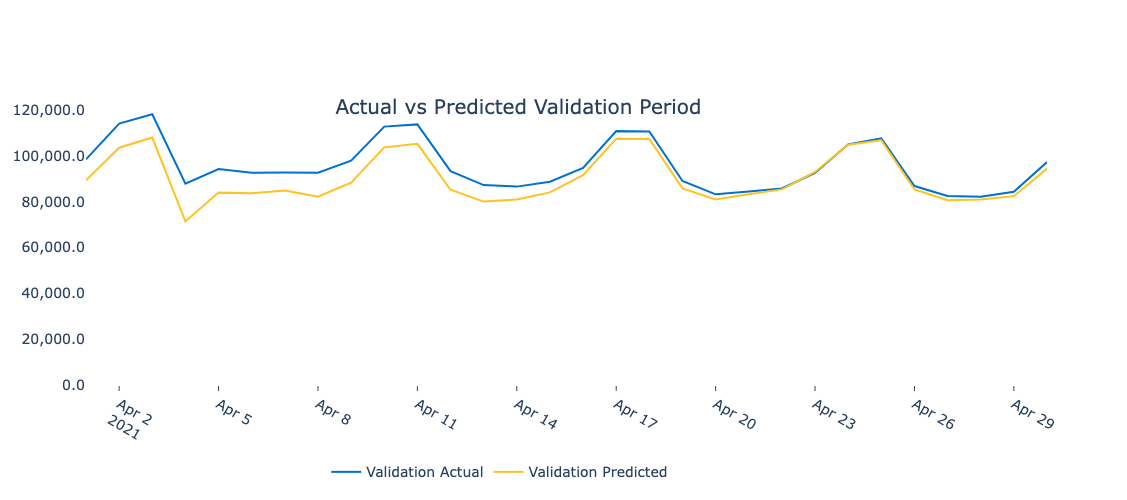

Display Level  Contribution Share (%)  \
0   National TV                        119.7                     
1   Offsite Display Pinterest          20.0                      
2   Onsite Display CT & ROS            31.1                      
3   Onsite Display homepage lockout    11.7                      
4   Onsite Display keyword             1.5                       
5   Search automatic                   6.5                       
6   Onsite Display audience targeting  10.4                      
7   SBA & SP manual                    0.9                       
8   Offsite Display Walmart Network    -101.8                    
9   Total Incremental                  1.4                       
10  Base                               98.6                      
11  Total                              100.0                     

   Total Contribution Total Sales ($) Total Spend ($)  Spend Share (%)  \
0   1,205,777          7,423,569       821,000        15.7               
1   201,009            1,237,545       153,829        2.9                
2   313,493            1,930,074       530,842        10.2               
3   117,822            725,390         309,611        5.9                
4   15,031             92,543          91,152         1.7                
5   65,143             401,066         875,518        16.7               
6   104,364            642,531         1,408,421      26.9               
7   9,019              55,528          383,354        7.3                
8   -1,024,717         -6,308,842      653,987        12.5               
9   1,006,942          6,199,405       5,227,714      100.0              
10  72,428,879         445,920,467     0              0.0                
11  73,435,821         452,119,872     5,227,714      0.0                

      Raw Media  Raw Media Share (%)  Volume RoAS  Value RoAS ($)  
0   38,023      0.0                  146.87       904.21           
1   24,512,012  6.7                  130.67       804.5            
2   59,525,879  16.4                 59.06        363.59           
3   49,996,954  13.8                 38.05        234.29           
4   5,597,978   1.5                  16.49        101.53           
5   603,489     0.2                  7.44         45.81            
6   120,901,509 33.3                 7.41         45.62            
7   197,757     0.1                  2.35         14.48            
8   101,900,937 28.1                 -156.69      -964.67          
9   363,274,538 100.0                19.26        118.59           
10  0           0.0                  0.0          0.0              
11  363,274,538 0.0                  0.0          0.0

In [30]:
model_obj.visualize_model_outputs('Manual Model 1', contribution_graph= False, add_residual= False, separate_validation= True,
                                  analyst_review= False, show_yaxis= True,
                                  )
model_obj.add_iteration_log('Manual Model 1')

In [31]:
run_tag

'220106_d2n3i20'

In [32]:
# look into the past runs
# load results

# total number of trial files to read from
nn = len(combins) 

nk = 0
media_variable0 = media_list[0]

for i in range(nn):
    saved_trials = folder_path + "model_trials_" + run_tag + "_{}.hyperopt".format(i)
    trials = pickle.load(open(saved_trials, "rb"))

# plot trials in each subspace iteration


# Dataframe of results from optimization
    tpe_results = pd.DataFrame({'loss': [x['loss'] for x in trials.results], 
                            'i': [ix + nk for ix in trials.idxs_vals[0][media_variable0 + '_INFLE'] ],
                            'x1': trials.idxs_vals[1][media_variable0 + '_LAG'],
                            'x2': trials.idxs_vals[1][media_variable0 + '_HALF'],
                            'x3': trials.idxs_vals[1][media_variable0 + '_INFLE'],
                            'x4': trials.idxs_vals[1][media_variable0 + '_SCALE'],
                            'x5': trials.idxs_vals[1][media_variable0 + '_CLEVEL'],
                           })

    print(i, 'minLoss=', tpe_results['loss'].min(), 'meanLoss=', tpe_results['loss'].mean(), nk)

    if i==0:
        trial_df = tpe_results.copy()
    else:
        trial_df = pd.concat([trial_df, tpe_results])
    nk = trial_df['i'].max()+1
                            
    


0 minLoss= 34127403.72136433 meanLoss= 1430544091.0268373 0
1 minLoss= 34552704.41776537 meanLoss= 41899768.60551502 20
2 minLoss= 39002611.07018341 meanLoss= 54865635.44207355 40
3 minLoss= 32696810.47993492 meanLoss= 43032538.11627764 60
4 minLoss= 32695533.230214756 meanLoss= 1491777802.4129362 80
5 minLoss= 25063043.214073595 meanLoss= 58401662.50078765 100
6 minLoss= 24713760.313434016 meanLoss= 34900338.16900814 120
7 minLoss= 23743547.812717594 meanLoss= 41425911.72920454 140
8 minLoss= 21549733.013426498 meanLoss= 29460242.359834094 160
9 minLoss= 31386512.73778444 meanLoss= 1473278526.4463062 180
10 minLoss= 23509777.481349494 meanLoss= 71407916.14476494 200
11 minLoss= 23066160.08636149 meanLoss= 34712322.91071336 220
12 minLoss= 22505316.533403575 meanLoss= 41355460.27627819 240
13 minLoss= 26672314.389323357 meanLoss= 37151970.932202175 260
14 minLoss= 24815318.39063972 meanLoss= 1406847120.071903 280
15 minLoss= 27657045.810197875 meanLoss= 68511712.53901908 300


Text(0.5, 0, 'iteration')

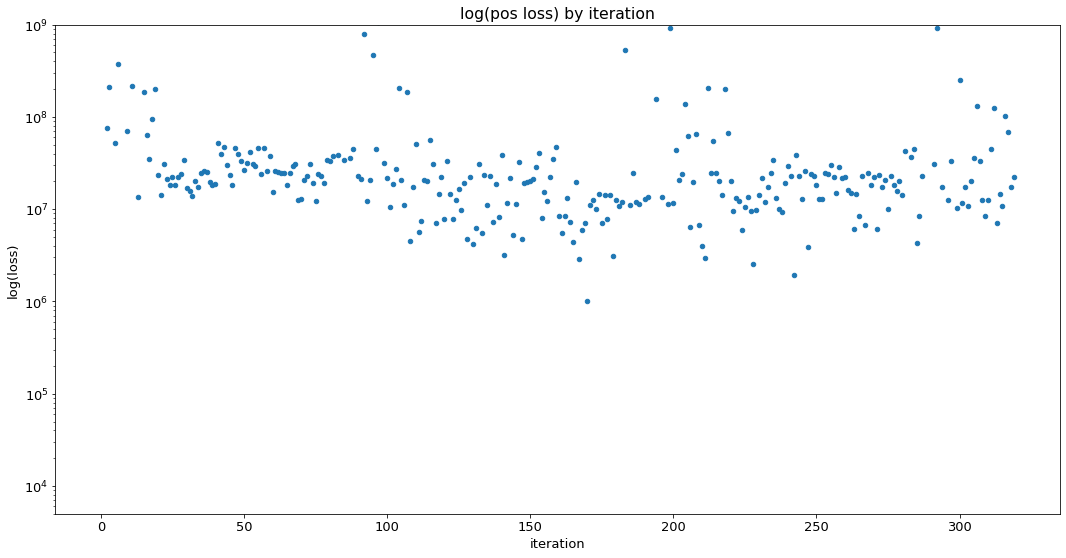

In [33]:
trial_df['posloss'] = trial_df['loss'] - trial_df['loss'].min() + 1000000

pt1 = trial_df.plot.scatter(x = 'i', y = 'posloss', logy=True,  figsize=(18,9))

pt1.set_ylim(5e3, 1e9)
pt1.set_title('log(pos loss) by iteration')
pt1.set_ylabel('log(loss)')
pt1.set_xlabel('iteration')

In [34]:
model_records_read = pd.read_csv(folder_path + "best_models_" + run_tag + ".csv")

In [35]:
# find the best case in the stored history

model_records = model_records_read.copy()

model_records_sorted = model_records.sort_values(['loss'])
model_records_sorted.reset_index(drop=True, inplace=True)

best_itr = model_records_sorted[model_records_sorted.index == 0]['itr'][0]

vars = model_records_sorted[ model_records_sorted['itr'] == best_itr]['Final Variables']

best_med_variables = vars.to_list()

best_med_variables

['M_OFF_DIS_WN_IMP_1_1_4.4_0.4_0.0',
 'M_ON_DIS_AT_IMP_1_5_5.2_2.8_0.0',
 'M_ON_DIS_CT_ROS_IMP_3_8_2.8_4.4_0.0',
 'M_SEARCH_MAN_CLK_2_2_3.6_4.0_0.0',
 'M_SEARCH_AUTO_CLK_2_1_6.8_6.4_0.0',
 'M_NATIONAL_TV_IMP_0_3_1.2_6.4_0.0',
 'M_OFF_DIS_PIN_IMP_11_5_5.2_4.4_0.0',
 'M_ON_DIS_HPLO_IMP_1_1_2.0_6.4_0.0',
 'M_ON_DIS_KW_IMP_3_2_6.0_2.4_0.0']

In [36]:
# from the best_model_8.csv
# get the media_variables you like or the one with lowest loss


media_vars = best_med_variables



In [37]:
# Creating the finale modelling object
model_obj1 = MMM_Modelling(df.copy(), target_var, data_dict= data_dict,
                              output_path= folder_path, media_hier= media_hier,
                              apply_adstock = True,
                              comment= 'Media Mix Model')

model_obj1.create_train_test_split( train_start, train_end, test_start, test_end)

# Selecting all the independent variables
#use media_variables in the modeling notebook
all_independent_variables = dummy_variables + media_vars + other_variables
model_obj1.create_missing_media_transformations(media_vars, 
                                               trans_start_date= train_start, trans_end_date= train_end)

model_obj1.create_model_results(X_vars= all_independent_variables, model_type= 'Manual Model 1')



Variables          Coefficient  \
0   INTERCEPT_TERM                              128,053.40840   
1   D_HOL_CHRISTMAS                              -6,329.20482   
2   D_NATIONAL_WEATHER                              111.49399   
3   D_HOL_THANKSGIVING                          -12,382.95766   
4   D_HOL_NEW_YEARS_DAY                          -4,257.74149   
5   D_HOL_EASTER                                 -9,676.94239   
6   D_EVENT_COVID_LOCKDOWN                       27,449.94452   
7   D_EVENT_PRE_SUPERBOWL                         2,389.86240   
8   D_DAY_SUNDAY                                    758.12175   
9   D_EVENT_COVID_STOCKUP                        35,306.80722   
10  D_EVENT_COVID_BURN                           -8,182.35442   
11  D_EVENT_EXTREME_COLD                         -7,868.24571   
12  M_OFF_DIS_WN_IMP_1_1_4.4_0.4_0.0                 -0.00595   
13  M_ON_DIS_AT_IMP_1_5_5.2_2.8_0.0                   0.00225   
14  M_ON_DIS_CT_ROS_IMP_3_8_2.8_4.4_0.0               0.00124   
15  M_SEARCH_MAN_CLK_2_2_3.6_4.0_0.0                  0.12250   
16  M_SEARCH_AUTO_CLK_2_1_6.8_6.4_0.0                 0.04486   
17  M_NATIONAL_TV_IMP_0_3_1.2_6.4_0.0                30.99571   
18  M_OFF_DIS_PIN_IMP_11_5_5.2_4.4_0.0                0.00660   
19  M_ON_DIS_HPLO_IMP_1_1_2.0_6.4_0.0                 0.00144   
20  M_ON_DIS_KW_IMP_3_2_6.0_2.4_0.0                   0.00269   
21  O_UNIT_SEASONALITY                                1.01004   
22  O_UNIT_RESIDUAL                                   0.88162   
23  INVENTORY_STORE_SELLABLE_ITEMS_COUNT            852.18889   
24  PRICE                                       -10,705.08462   

                p-value         Significance           Elasticity  \
0               0.00000            100.00000              0.00000   
1               0.20100             79.90000             -0.00017   
2               0.05200             94.80000              0.00387   
3               0.00500             99.50000             -0.00034   
4               0.19800             80.20000             -0.00017   
5               0.02000             98.00000             -0.00026   
6               0.00000            100.00000              0.00037   
7               0.47400             52.60000              0.00010   
8               0.22800             77.20000              0.00121   
9               0.00000            100.00000              0.01010   
10              0.00000            100.00000             -0.00312   
11              0.01700             98.30000             -0.00032   
12              0.00100             99.90000             -0.00815   
13              0.00000            100.00000              0.00361   
14              0.02400             97.60000              0.00097   
15              0.56000             44.00000              0.00033   
16              0.11700             88.30000              0.00037   
17              0.00000            100.00000              0.01605   
18              0.00300             99.70000              0.00219   
19              0.11000             89.00000              0.00095   
20              0.18100             81.90000              0.00020   
21              0.00000            100.00000             -0.00026   
22              0.00000            100.00000             -0.00007   
23              0.00000            100.00000              0.27889   
24              0.00000            100.00000             -0.73837   

    Standardized Coefficient  Relative Importance                  VIF  
0               0.00000                   0.00000              0.00000  
1              -0.01990                   0.00048              1.55497  
2               0.02810                   0.00095              1.33253  
3              -0.03900                   0.00184              1.22047  
4              -0.01640                   0.00032              1.03724  
5              -0.03050                   0.00112              1.09188  
6               0.06120           

Model Fit   Validation Metrics
MAPE                           6.60555              3.83252
R Square                      87.53526             84.41676
Adjusted R Sqaure             87.15944                     
AIC                       16,528.22240                     
BIC                       16,645.98548                     
Log Likelihood            -8,239.11120

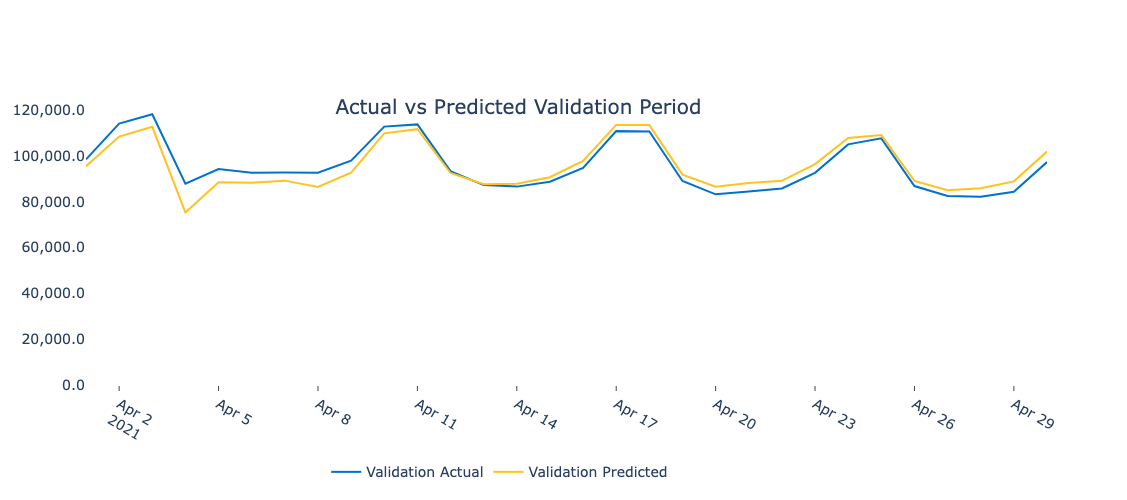

Display Level  Contribution Share (%)  \
0   National TV                        96.7                      
1   Offsite Display Pinterest          13.2                      
2   Onsite Display homepage lockout    5.9                       
3   Onsite Display audience targeting  22.2                      
4   Onsite Display keyword             1.2                       
5   Onsite Display CT & ROS            6.0                       
6   SBA & SP manual                    2.0                       
7   Search automatic                   2.2                       
8   Offsite Display Walmart Network    -49.5                     
9   Total Incremental                  1.7                       
10  Base                               98.3                      
11  Total                              100.0                     

   Total Contribution Total Sales ($) Total Spend ($)  Spend Share (%)  \
0   1,178,535          7,255,850       821,000        15.7               
1   160,965            991,005         153,829        2.9                
2   71,796             442,021         309,611        5.9                
3   270,776            1,667,078       1,408,421      26.9               
4   14,965             92,137          91,152         1.7                
5   73,562             452,897         530,842        10.2               
6   24,173             148,823         383,354        7.3                
7   26,889             165,549         875,518        16.7               
8   -603,360           -3,714,686      653,987        12.5               
9   1,218,301          7,500,675       5,227,714      100.0              
10  72,217,519         444,619,198     0              0.0                
11  73,435,821         452,119,872     5,227,714      0.0                

      Raw Media  Raw Media Share (%)  Volume RoAS  Value RoAS ($)  
0   38,023      0.0                  143.55       883.78           
1   24,512,012  6.7                  104.64       644.23           
2   49,996,954  13.8                 23.19        142.77           
3   120,901,509 33.3                 19.23        118.37           
4   5,597,978   1.5                  16.42        101.08           
5   59,525,879  16.4                 13.86        85.32            
6   197,757     0.1                  6.31         38.82            
7   603,489     0.2                  3.07         18.91            
8   101,900,937 28.1                 -92.26       -568.01          
9   363,274,538 100.0                23.3         143.48           
10  0           0.0                  0.0          0.0              
11  363,274,538 0.0                  0.0          0.0

In [38]:
model_obj1.visualize_model_outputs('Manual Model 1', contribution_graph= False, add_residual= False, separate_validation= True,
                                  analyst_review= False, show_yaxis= True,
                                  )
model_obj1.add_iteration_log('Manual Model 1')